# Scrambling of operators

In [2]:
using ITensors
using ITensorTDVP
using Plots
using Observers
using LinearAlgebra

In [40]:
N  = 21    # Number of spins
J  = 1.0    # ZZ interaction strength
hx = 1.05   # X-field 
hz = 0.5    # Z-field
δt = 0.05   # Time-step for evolution
T  = 1.0   # Total time
χ  = 32;    # Max link dimension allowed

## Extended system + ancilla

In [4]:
# sitesext = siteinds("S=1/2",2*N); # Make 2N S=1/2 spin indices defining system + ancilla

sitesext = siteinds("Boson",2*N, dim=5); # Make 2N Bosonic indices defining system + ancilla

In [5]:
# Extract the raising, lowering and identity operators for the extended system:

# Sp = ops(sitesext, [("S+", n) for n in 1:(2*N)]);  # Raising operators
# Sm = ops(sitesext, [("S-", n) for n in 1:(2*N)]);  # Lowering operators
A = ops(sitesext, [("a", n) for n in 1:(2*N)]);  # Annihilation operator
Adag = ops(sitesext, [("adag", n) for n in 1:(2*N)]);  # Creation operator
Adag_2 = ops(sitesext, [("adag * adag", n) for n in 1:(2*N)])
Adag_3 = ops(sitesext, [("adag * adag * adag", n) for n in 1:(2*N)])
Adag_4 = ops(sitesext, [("adag * adag * adag * adag", n) for n in 1:(2*N)])


# ITensors doesn't include the identity operator as standard so construct it:
Id = Vector{ITensor}(undef,2*N)
for i =1:(2*N)
    iv = sitesext[i]
    ID = ITensor(iv', dag(iv));
    for j in 1:ITensors.dim(iv)
        ID[iv' => j, iv => j] = 1.0
    end
    Id[i] = ID
end;

In [6]:
# Construct the identity vacuum state:

Ivac = MPS(sitesext, "0") # All 0 spins
# Ivac = MPS(sitesext, "Up") # All up spins initial state
# 1:2:(2*N) from 1 to 2N in steps of 2
######################################################
# Write code that takes dim and writes Ivac
######################################################
# (I-Z)/2 to spin chain should give same as applying n to bosons
#####
gates = [(Id[n]*Id[n+1] + Adag[n]*Adag[n+1] + Adag_2[n]*Adag_2[n+1]*(1/2) + Adag_3[n]*Adag_3[n+1]*(1/6) +
        Adag_4[n]*Adag_4[n+1]*(1/24)) for n in 1:2:(2*N)]; # Maps |00> => |00> + |11> + |22> + |33> + |44>
#  gates = [(Id[n]*Id[n+1] + Sm[n]*Sm[n+1]) for n in 1:2:(2*N)];
Ivac = apply(gates, Ivac; cutoff=1e-15); # Note we have no 1/sqrt(2) normalisation

In [29]:
# Vectorisation approach used here is to stack matrix rows into a column vector.
# This means that:
# vec(AB) = A ⊗ I vec(B) =  I ⊗ B^T vec(A)
# so |i><j| => |i> ⊗ |j>
# vec(L A R) = L ⊗ R^T vec(A)

# Define "Commutator" Hamiltonian operator terms:

# HC = H ⊗ I - I ⊗ H, since H is real and hermitian H = H^T.
t = 1.0
U = 0.1
μ = 1.0
H_op = OpSum()
# for i=1:2*(N-1)
#     H_op += (-1)^(i-1) *  J,"Sz",i,"Sz",i+2
# end
# for i=1:2*N
#     H_op += (-1)^(i-1) *  hx,"Sx",i
#     H_op += (-1)^(i-1) *  hz,"Sz",i
# end

#################
# Bose Hubbard Hamiltonian
####################
for i=1:2*(N-1)
    H_op += (-1)^(i) * t,"adag", i, "a", i+2 # system and system + 1
    H_op += (-1)^(i) * t,"a", i, "adag", i+2 # system and system + 1
    # needs to be -t Σ(b†i bj + bi b†j) so (-1)^(i) as opposed to ^(i-1)
end

for i=1:2*N
    H_op += (-1)^(i-1) * U/2, "n",i,"n", i
    H_op += (-1)^(i) * U/2, "n",i # -1 factor
    H_op += (-1)^(i) * μ, "n", i
end 

# Convert these terms to an MPO
HC = MPO(H_op,sitesext);

In [8]:
# Define observable for scrambling:

A_op = OpSum()
A_op += 1.0,"n",2*floor(Int,N/2+1)-1  # Sx operator in the middle of the system
A = MPO(A_op,sitesext);                # Build the MPO from these terms
Avec = apply(A, Ivac; cutoff=1e-15);   # Compute |A> = A|I>
#put adag + a

## Perform TDVP time evolution of the operator

In [9]:
# Define function for computing entanglement entropy

function entanglement_entropy(ψ)
# Compute the von Neumann entanglement entropy across each bond of the MPS
    N = length(ψ)
    SvN = zeros(N)
    psi = ψ
    for b=1:N
        psi = orthogonalize(psi, b)
        if b==1
            U,S,V = svd(psi[b] , siteind(psi, b))
        else
            U,S,V = svd(psi[b], (linkind(psi, b-1), siteind(psi, b)))
        end
        p = diag(S).^2               # Extract square of Schmidt coefficients
        p = p ./ sum(p)              # Normalise to a probability dist
        SvN[b] = -sum(p .* log2.(p)) # Compute Shannon entropy
    end
    return SvN
end;

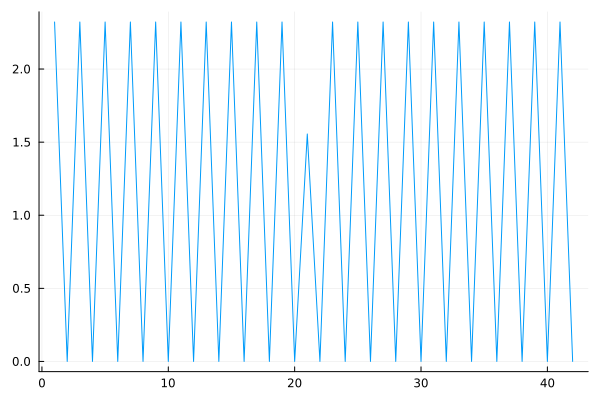

In [10]:
SvN_init = entanglement_entropy(Avec);
plot(1:(2*N), SvN_init, label=false) 

Here $|A>$ displays the entanglement structure of the initial vacuum state.

In [36]:
# Define observer functions for TDVP:

function current_time(; current_time, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return real(-im*current_time)
  end
    
  return nothing
end

function measure_SvN(; psi, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return entanglement_entropy(psi)
  end
  return nothing
end;

function measure_linkdim(; psi, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return maxlinkdim(psi)
  end
  return nothing
end;

In [12]:
# XX + YY spin hamiltonian
# killing of the spin at middle site
# map bosonic operators to spin operators
# annihilation is 1 on bottom, 0 on diagonal
# analytically solvable
# map to fermions, jordan-wigner transformations
# expect trivial solution as integrable, operator complexity bounded by a adag

# similar to ising model
# render as free fermi system
# solvable 

# try XX + YY model using heisenberg, confirm trivial

# bosonic operators annihiate one term from superposition
# Sx, Sz doesnt
# z nonzero, doesnt destroy entanglement


In [41]:
# Perform TDVP evolution of |A(t)>:

obs = Observer("times" => current_time, "SvN" => measure_SvN, "chi" => measure_linkdim)

# d|A(t)>/dt = i HC |A(t)> so |A(t)> = exp(i t HC)|A(0)> 

ψf = tdvp(HC, im * T, Avec; 
          time_step = im * δt,
          normalize = false, 
          maxdim = χ,
          cutoff = 1e-10,
          outputlevel=1,
          (observer!)=obs)

# Extract results from time-step observations
#`observer.name` or `observer[!, "name"]`
#res = results(obs)
times = obs.times
SvN = obs.SvN
chi = obs.chi
;
# times = res["times"]
# SvN = res["SvN"]
# chi = res["chi"];

After sweep 1: maxlinkdim=16 maxerr=8.18E-11 current_time=0.0 + 0.05im time=1.536


After sweep 2: maxlinkdim=32 maxerr=2.55E-10 current_time=0.0 + 0.1im time=3.807


After sweep 3: maxlinkdim=32 maxerr=8.97E-09 current_time=0.0 + 0.15im time=5.641


After sweep 4: maxlinkdim=32 maxerr=9.02E-08 current_time=0.0 + 0.2im time=7.093


After sweep 5: maxlinkdim=32 maxerr=4.13E-07 current_time=0.0 + 0.25im time=8.313


After sweep 6: maxlinkdim=32 maxerr=1.50E-06 current_time=0.0 + 0.3im time=9.375


After sweep 7: maxlinkdim=32 maxerr=4.23E-06 current_time=0.0 + 0.35im time=11.047


After sweep 8: maxlinkdim=32 maxerr=1.01E-05 current_time=0.0 + 0.4im time=16.654


After sweep 9: maxlinkdim=32 maxerr=2.08E-05 current_time=0.0 + 0.45im time=12.936


After sweep 10: maxlinkdim=32 maxerr=3.70E-05 current_time=0.0 + 0.5im time=14.498


After sweep 11: maxlinkdim=32 maxerr=5.63E-05 current_time=0.0 + 0.55im time=18.503


After sweep 12: maxlinkdim=32 maxerr=7.60E-05 current_time=0.0 + 0.6im time=30.984


After sweep 13: maxlinkdim=32 maxerr=9.69E-05 current_time=0.0 + 0.65im time=11.703


After sweep 14: maxlinkdim=32 maxerr=1.22E-04 current_time=0.0 + 0.7im time=12.838


After sweep 15: maxlinkdim=32 maxerr=1.52E-04 current_time=0.0 + 0.75im time=14.224


After sweep 16: maxlinkdim=32 maxerr=1.88E-04 current_time=0.0 + 0.8im time=3434.92


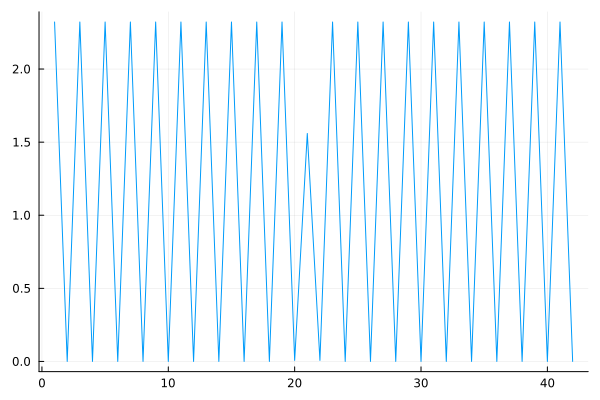

In [39]:
plot(1:(2*N), SvN[4], label=false) 

In [32]:
chi[1]

10

In [21]:
ψf

MPS
[1] ((dim=5|id=554|"Link,n=1"), (dim=5|id=902|"Boson,Site,n=1"))
[2] ((dim=20|id=137|"Link,l=2"), (dim=5|id=757|"Boson,Site,n=2"), (dim=5|id=554|"Link,n=1"))
[3] ((dim=32|id=289|"Link,n=1"), (dim=5|id=18|"Boson,Site,n=3"), (dim=20|id=137|"Link,l=2"))
[4] ((dim=32|id=133|"Link,l=4"), (dim=5|id=335|"Boson,Site,n=4"), (dim=32|id=289|"Link,n=1"))
[5] ((dim=32|id=112|"Link,n=1"), (dim=5|id=533|"Boson,Site,n=5"), (dim=32|id=133|"Link,l=4"))
[6] ((dim=32|id=294|"Link,l=6"), (dim=5|id=224|"Boson,Site,n=6"), (dim=32|id=112|"Link,n=1"))
[7] ((dim=32|id=462|"Link,n=1"), (dim=5|id=597|"Boson,Site,n=7"), (dim=32|id=294|"Link,l=6"))
[8] ((dim=32|id=829|"Link,l=8"), (dim=5|id=75|"Boson,Site,n=8"), (dim=32|id=462|"Link,n=1"))
[9] ((dim=32|id=800|"Link,n=1"), (dim=5|id=785|"Boson,Site,n=9"), (dim=32|id=829|"Link,l=8"))
[10] ((dim=32|id=667|"Link,l=10"), (dim=5|id=845|"Boson,Site,n=10"), (dim=32|id=800|"Link,n=1"))
[11] ((dim=32|id=53|"Link,n=1"), (dim=5|id=942|"Boson,Site,n=11"), (dim=32|id=667|"Li

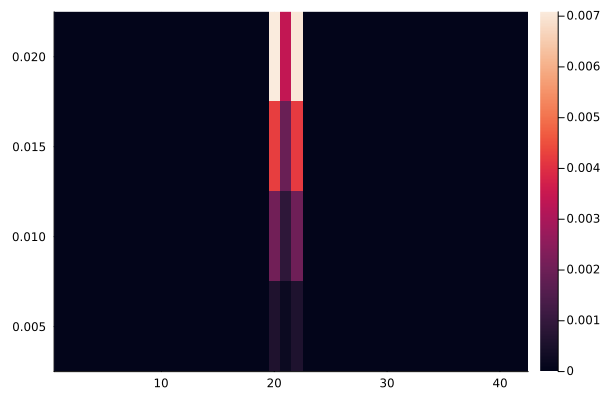

In [33]:
# Plot the entanglement entropy of each bond for system + ancilla:
gr() #### c = :heat
heatmap(1:(2*N), times, reduce(vcat,transpose.(SvN)), c = :seaborn_rocket_gradient)

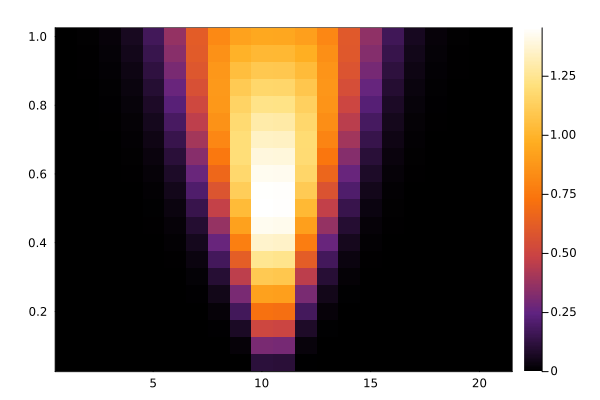

In [16]:
using Plots.PlotMeasures
# Plot the entanglement entropy for bonds separating system + ancilla pairs:
gr()
S = reduce(vcat,transpose.(SvN))[:,2:2:(2*N)]
heatmap(1:N, times, S, c = :sunset,left_margin=20px, right_margin=20px, top_margin=20px, framestyle=:box)

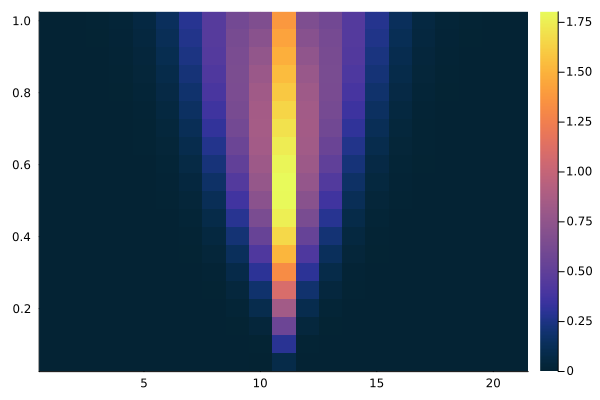

In [17]:
# Plot entanglement entropy of bonds between system + ancilla pairs:
gr()
S = reduce(vcat,transpose.(SvN))[:,1:2:(2*N)]
heatmap(1:N, times, S, c = :thermal)

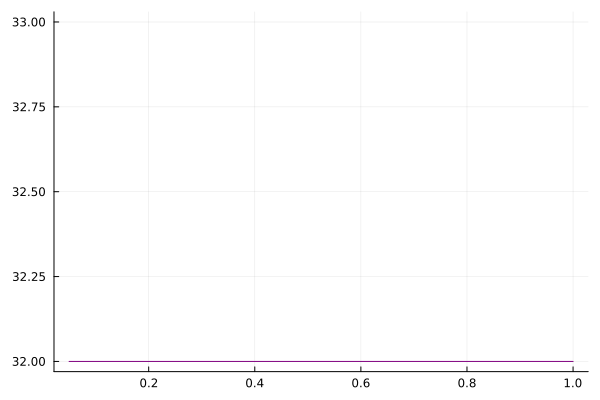

In [18]:
# Plot the growth in the maximum link dimension with time:
plot(times, chi, label=false, linecolor="purple")  
#scatter!(times, chi, label=false) 